In [3]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Лабораторная работа №5

Анализ погодных данных из файла `weather1.csv` (Пермь).

В работе используются как минимум две библиотеки визуализации: **matplotlib** и **seaborn**.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

REQUIRED_COLS = [
    'Местное время в Перми',
    'T',
    'P',
    'U',
    'Ff',
    'N',
    'H',
    'VV',
]

In [5]:
def read_weather_csv(path: str) -> pd.DataFrame:
    last_error = None
    for sep in [';', ',']:
        try:
            return pd.read_csv(path, sep=sep, usecols=REQUIRED_COLS, encoding='utf-8')
        except Exception as e:
            last_error = e
    raise RuntimeError(f'Не удалось прочитать {path}. Последняя ошибка: {last_error}')

def to_numeric(series: pd.Series) -> pd.Series:
    cleaned = (
        series.astype(str)
        .str.replace(',', '.', regex=False)
        .str.extract(r'(-?\d+(?:\.\d+)?)', expand=False)
    )
    return pd.to_numeric(cleaned, errors='coerce')

df = read_weather_csv('weather1.csv')

df['Местное время в Перми'] = pd.to_datetime(df['Местное время в Перми'], errors='coerce', dayfirst=True)
for col in ['T', 'P', 'U', 'Ff', 'VV']:
    df[col] = to_numeric(df[col])

# N может содержать текстовые значения; извлекаем процент облачности для логики из задания
df['N_num'] = to_numeric(df['N'])

print('Размер данных:', df.shape)
display(df.head())
display(df.info())

Размер данных: (2919, 9)


,Местное время в Перми,T,P,U,Ff,N,H,VV,N_num
0,2021-12-31 23:00:00,-9.8,762.5,83,3,100%.,600-1000,4.0,100.0
1,2021-12-31 20:00:00,-10.6,764.2,81,3,100%.,1000-1500,4.0,100.0
2,2021-12-31 17:00:00,-11.6,765.5,79,2,"90 или более, но не 100%",1000-1500,10.0,90.0
3,2021-12-31 14:00:00,-11.9,766.7,77,1,100%.,1000-1500,20.0,100.0
4,2021-12-31 11:00:00,-13.6,767.5,79,1,100%.,1000-1500,10.0,100.0


<class 'pandas.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Местное время в Перми  2919 non-null   datetime64[us]
 1   T                      2919 non-null   float64       
 2   P                      2917 non-null   float64       
 3   U                      2919 non-null   int64         
 4   Ff                     2919 non-null   int64         
 5   N                      2916 non-null   str           
 6   H                      2551 non-null   str           
 7   VV                     2917 non-null   float64       
 8   N_num                  2551 non-null   float64       
dtypes: datetime64[us](1), float64(4), int64(2), str(2)
memory usage: 205.4 KB


None

## 2. Точечная диаграмма: температура vs влажность

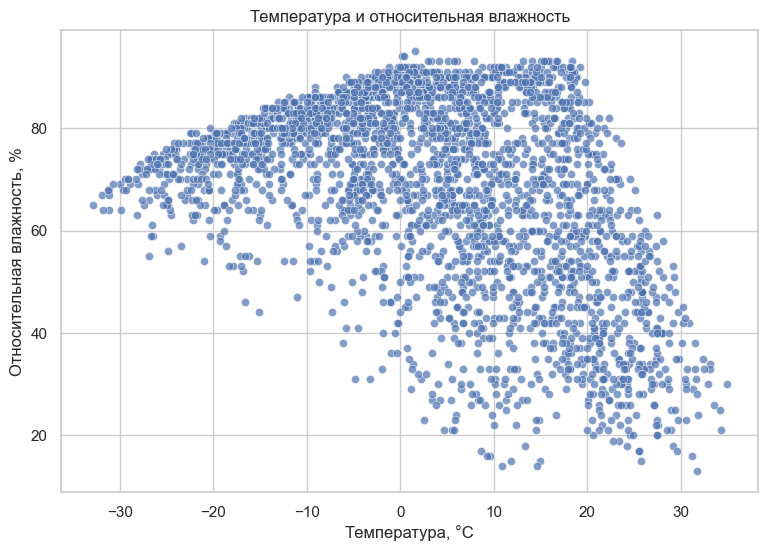

In [7]:
plt.figure(figsize=(9, 6))
sns.scatterplot(data=df, x='T', y='U', s=35, alpha=0.7)
plt.title('Температура и относительная влажность')
plt.xlabel('Температура, °C')
plt.ylabel('Относительная влажность, %')
plt.show()

## 3. Раскраска точек по облачности (синий = 100%, красный = остальные)

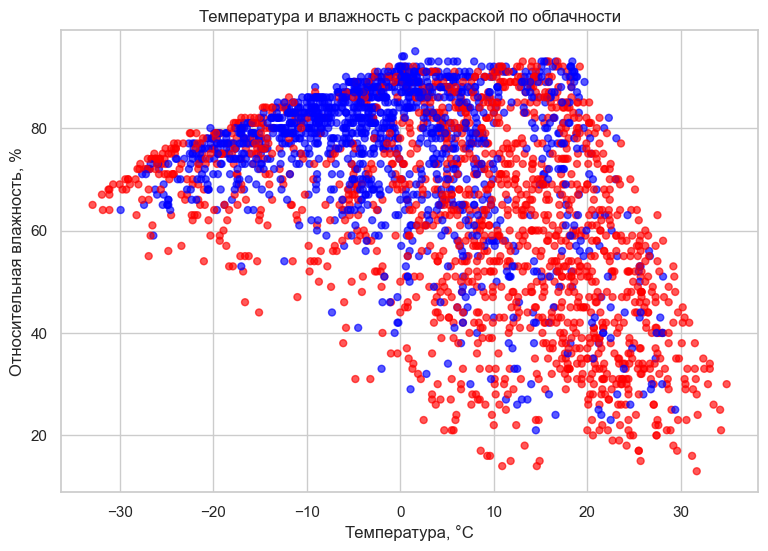

In [8]:
is_full_cloud = df['N_num'].eq(100)
colors = np.where(is_full_cloud, 'blue', 'red')

plt.figure(figsize=(9, 6))
plt.scatter(df['T'], df['U'], c=colors, alpha=0.65, s=25)
plt.title('Температура и влажность с раскраской по облачности')
plt.xlabel('Температура, °C')
plt.ylabel('Относительная влажность, %')
plt.show()

## 4. Линейный график температуры по времени

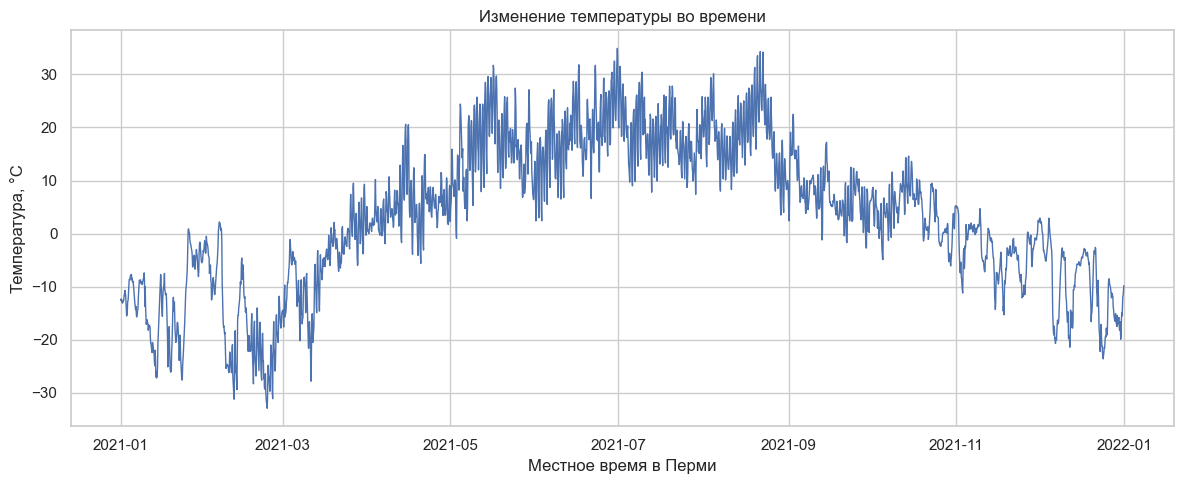

In [9]:
df_time = df.dropna(subset=['Местное время в Перми', 'T']).sort_values('Местное время в Перми')

plt.figure(figsize=(12, 5))
plt.plot(df_time['Местное время в Перми'], df_time['T'], linewidth=1)
plt.title('Изменение температуры во времени')
plt.xlabel('Местное время в Перми')
plt.ylabel('Температура, °C')
plt.tight_layout()
plt.show()

## 5. Среднемесячная температура и столбчатая диаграмма

,month,T
0,1,-12.958871
1,2,-17.419643
2,3,-5.660484
3,4,5.382500
4,5,16.275806
5,6,18.898333
6,7,18.444355
7,8,18.568145
8,9,7.556067
9,10,4.207258


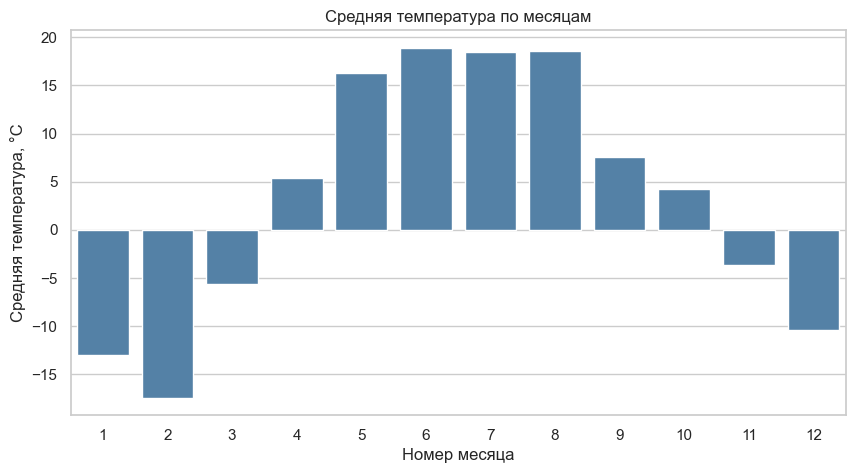

In [10]:
df['month'] = df['Местное время в Перми'].dt.month
monthly_temp = df.groupby('month', dropna=True)['T'].mean().reset_index()
monthly_temp = monthly_temp.sort_values('month')

display(monthly_temp)

plt.figure(figsize=(10, 5))
sns.barplot(data=monthly_temp, x='month', y='T', color='steelblue')
plt.title('Средняя температура по месяцам')
plt.xlabel('Номер месяца')
plt.ylabel('Средняя температура, °C')
plt.show()

## 6. Горизонтальная ленточная диаграмма количества наблюдений по облачности

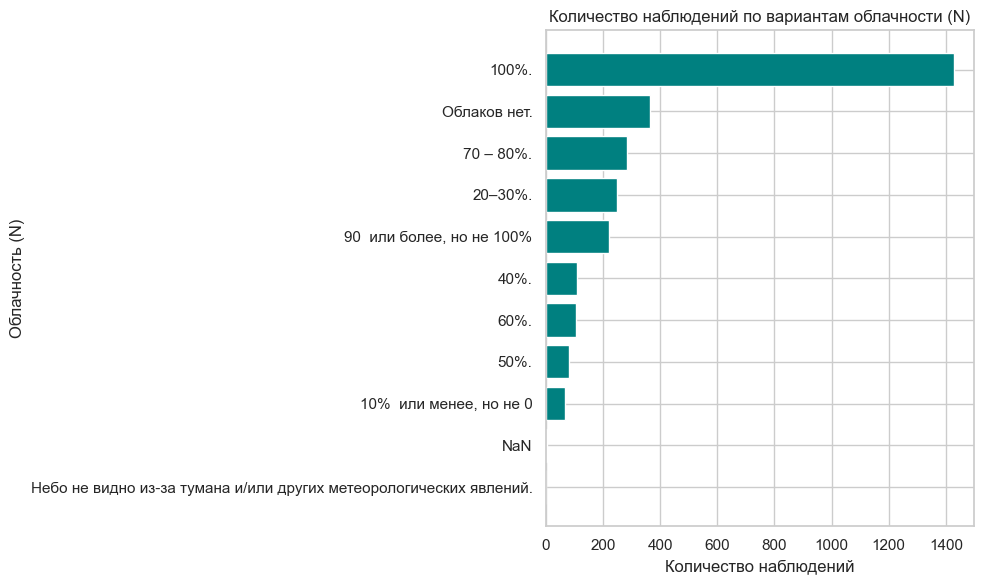

In [11]:
cloud_counts = df['N'].astype(str).fillna('NaN').value_counts().sort_values()

plt.figure(figsize=(10, 6))
plt.barh(cloud_counts.index, cloud_counts.values, color='teal')
plt.title('Количество наблюдений по вариантам облачности (N)')
plt.xlabel('Количество наблюдений')
plt.ylabel('Облачность (N)')
plt.tight_layout()
plt.show()

## 7. Гистограмма частот температуры (10 диапазонов)

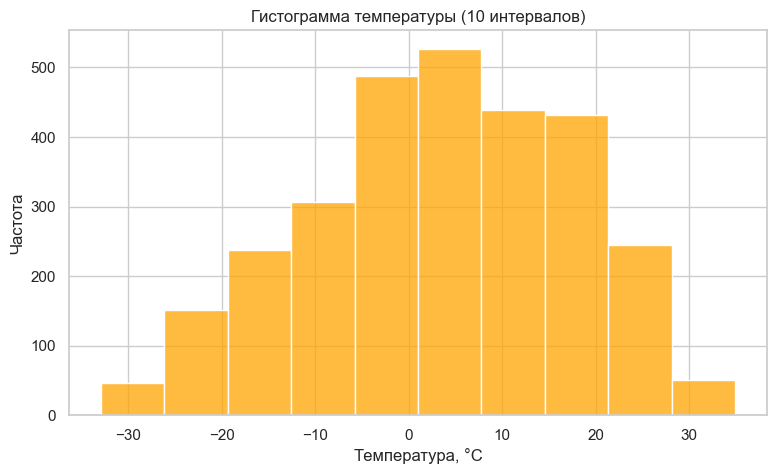

In [12]:
plt.figure(figsize=(9, 5))
sns.histplot(df['T'].dropna(), bins=10, kde=False, color='orange')
plt.title('Гистограмма температуры (10 интервалов)')
plt.xlabel('Температура, °C')
plt.ylabel('Частота')
plt.show()

## 8. Boxplot давления по группам видимости

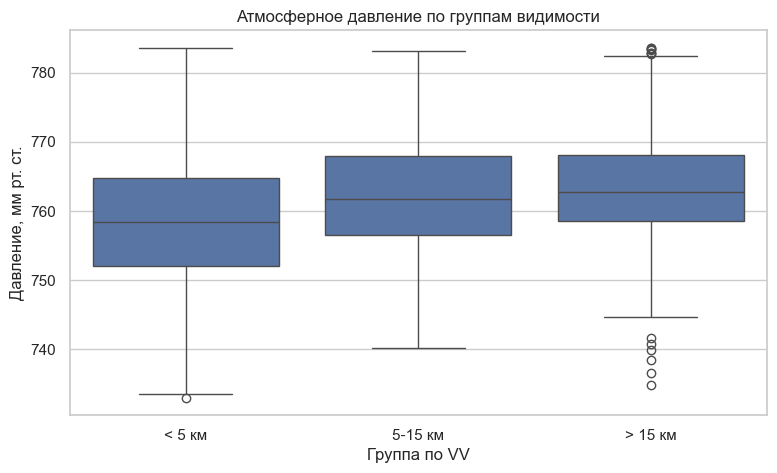

In [13]:
df['VV_group'] = pd.cut(
    df['VV'],
    bins=[-np.inf, 5, 15, np.inf],
    labels=['< 5 км', '5-15 км', '> 15 км'],
    include_lowest=True,
    right=True
)

plt.figure(figsize=(9, 5))
sns.boxplot(data=df, x='VV_group', y='P', order=['< 5 км', '5-15 км', '> 15 км'])
plt.title('Атмосферное давление по группам видимости')
plt.xlabel('Группа по VV')
plt.ylabel('Давление, мм рт. ст.')
plt.show()

## 9. Круговая диаграмма по высоте основания облаков (H)

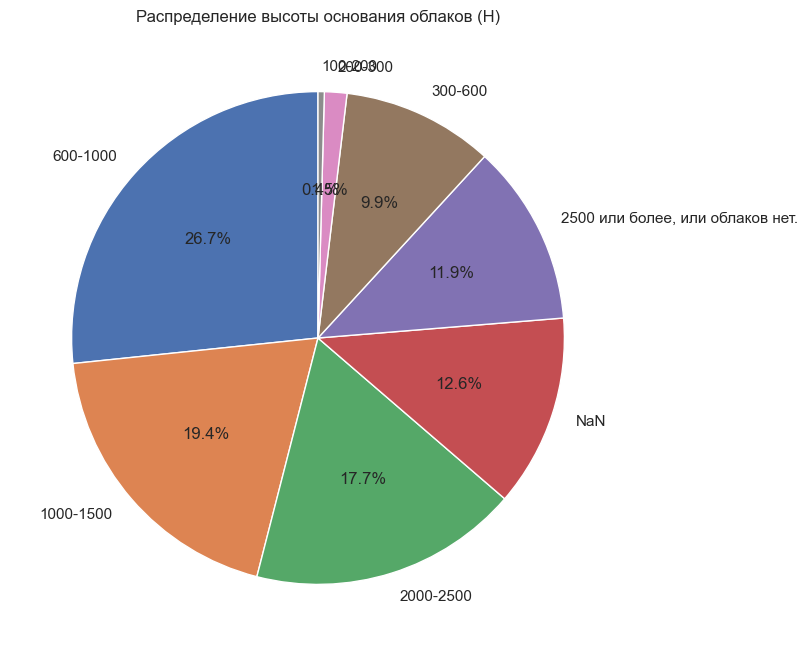

In [14]:
h_counts = df['H'].astype(str).fillna('NaN').value_counts()

# Чтобы диаграмма оставалась читаемой при большом числе категорий
if len(h_counts) > 10:
    top = h_counts.head(10)
    other_sum = h_counts.iloc[10:].sum()
    h_counts_plot = pd.concat([top, pd.Series({'Прочие': other_sum})])
else:
    h_counts_plot = h_counts

plt.figure(figsize=(8, 8))
plt.pie(h_counts_plot.values, labels=h_counts_plot.index, autopct='%1.1f%%', startangle=90)
plt.title('Распределение высоты основания облаков (H)')
plt.show()